People Detection Project

Setup & Installs:

In [1]:
!pip -q install --upgrade ultralytics==8.3.40 kaggle opencv-python pandas==2.2.2 matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 137.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 16.0 MB/s eta 0:00:00


In [2]:
# All imports are done first
import os, random, zipfile, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import files
from ultralytics import YOLO

# Reproducibility
random.seed(42)
np.random.seed(42)

# GPU Check
import torch

print("CUDA working: ", torch.cuda.is_available())
print("GPU name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Path Setups
root = Path("/content")
data_root = root / "people_detection"
work_root = root / "people_detection_subset"
image_exts = (".jpg", ".jpeg", ".png")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA working:  True
GPU name:  NVIDIA A100-SXM4-80GB


In [3]:
# Clean old subsets for safe reruns
if work_root.exists():
  print("Removing old subset")
  shutil.rmtree(work_root)
work_root.mkdir(parents = True, exist_ok = True)

Dataset Download & Subset Creation:

In [4]:
# Download and extract dataset from Kaggle
print("Upload kaggle api token here: ")

if not (Path("/root/.kaggle/kaggle.json").exists()):
  files.upload()
  !mkdir -p /root/.kaggle
  !mv kaggle.json /root/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json

if not list(data_root.glob("*.zip")):
  print("Downloading dataset from Kaggle")
  !kaggle datasets download -d adilshamim8/people-detection -p "$data_root" --force

  zip_path = next(data_root.glob("*.zip"))
  with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(data_root)
else:
  print("Dataset already downloaded")

print("Folder tree (top levels): ")
!find "$data_root" -maxdepth 2 -type d -print | head -n 20

Upload kaggle api token here: 


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adilshamim8/people-detection
License(s): Attribution-NoDerivatives 4.0 International (CC BY-ND 4.0)
100% 1.94G/1.94G [01:30<00:00, 23.9MB/s]
100% 1.94G/1.94G [01:30<00:00, 23.1MB/s]
Folder tree (top levels): 
/content/people_detection
/content/people_detection/test
/content/people_detection/test/test
/content/people_detection/valid
/content/people_detection/valid/valid
/content/people_detection/train
/content/people_detection/train/train


In [5]:
# Get a subset with 20% of the data with maximum images set to 3000
def collect_images(base: Path):
  return sorted([p for p in base.rglob("*") if p.suffix.lower() in image_exts])

all_images = collect_images(data_root)
print(f"Total images found: {len(all_images)}")

subset_fraction = 0.20
n_target = int(len(all_images) * subset_fraction)
n_max = 3000
n_subset = min(n_target, n_max)
print(f"Using {n_subset} images (20% of the total data, capped at {n_max})")

subset_images = random.sample(all_images, n_subset)
random.shuffle(subset_images)
split_idx = int(len(subset_images) * 0.8)
subset_train_images = subset_images[:split_idx]
subset_val_images = subset_images[split_idx:]
print(f"Subset split: {len(subset_train_images)} train / {len(subset_val_images)} val")

images_train = work_root / "images/train"
images_val = work_root / "images/val"
labels_train = work_root / "labels/train"
labels_val = work_root / "labels/val"

for p in [images_train, images_val, labels_train, labels_val]:
  p.mkdir(parents = True, exist_ok = True)

def safe_link(src: Path, dst: Path):
  try:
    os.symlink(src, dst)
  except:
    shutil.copy(src, dst)

for img in subset_train_images:
  safe_link(img, images_train / img.name)

for img in subset_val_images:
  safe_link(img, images_val / img.name)

print("Subset images copied into work_root.")

Total images found: 17401
Using 3000 images (20% of the total data, capped at 3000)
Subset split: 2400 train / 600 val
Subset images copied into work_root.


Pseudo-Label Generation (YOLOv8n):

In [6]:
# Generate pseudo labels using pretrained YOLOv8n
train_labels = list(labels_train.glob("*.txt"))
val_labels = list(labels_val.glob("*.txt"))
print(f"Train labels: {len(train_labels)}")
print(f"Val labels: {len(val_labels)}")

if len(train_labels) == 0 and len(val_labels) == 0:
    print("No labels found. YOLOv8n will generate pseudo labels.")
    base_model = YOLO("yolov8n.pt")

    def pseudo_label_stream(model, img_folder: Path, label_folder: Path, conf=0.35, iou=0.5, imgsz=640):
      label_folder.mkdir(parents = True, exist_ok = True)

      results = model.predict(
          source = str(img_folder),
          imgsz = imgsz,
          conf = conf,
          iou = iou,
          stream = True,
          verbose = False,
          max_det = 200
      )

      n_files = 0
      for r in results:
        img_path = Path(r.path)
        h, w = r.orig_shape
        lines = []

        if r.boxes is not None:
          for b in r.boxes:
            if int(b.cls.item()) != 0:
              continue

            x1, y1, x2, y2 = b.xyxy[0].tolist()
            cx = ((x1 + x2) / 2.0) / w
            cy = ((y1 + y2) / 2.0) / h
            bw = (x2 - x1) / w
            bh = (y2 - y1) / h
            lines.append(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        if lines:
          label_path = label_folder / f"{img_path.stem}.txt"
          with open(label_path, "w") as f:
            f.write("\n".join(lines))
          n_files += 1

      print(f"Pseudo labels written in {label_folder}: {n_files}")

    pseudo_label_stream(base_model, images_train, labels_train)
    pseudo_label_stream(base_model, images_val, labels_val)
else:
  print("Pseudo labels already generated.")

print("Pseudo labeling done.")

Train labels: 0
Val labels: 0
No labels found. YOLOv8n will generate pseudo labels.


100%|██████████| 6.25M/6.25M [00:00<00:00, 384MB/s]


Pseudo labels written in /content/people_detection_subset/labels/train: 1998
Pseudo labels written in /content/people_detection_subset/labels/val: 506
Pseudo labeling done.


In [7]:
# Create data.yaml for this subset
data_yaml = work_root / "people_subset.yaml"

data_yaml.write_text(
    f"path: {work_root}\n"
    f"train: images/train\n"
    f"val: images/val\n"
    f"names:\n"
    f"  0: person\n"
)

print("data.yaml:\n", data_yaml.read_text())

data.yaml:
 path: /content/people_detection_subset
train: images/train
val: images/val
names:
  0: person



Hyperparameter Search (CFG1 vs CFG2):

In [8]:
# Hyperparameter search (2 configurations used, 8 and 10 epochs, YOLOv8n)
configurations = [
    {"name": "cfg1", "epochs": 8, "imgsz": 640, "lr0": 0.002},
    {"name": "cfg2", "epochs": 10, "imgsz": 768, "lr0": 0.0015},
]

runs_dir = root / "runs_people_yolo"
runs_dir.mkdir(parents=True, exist_ok=True)

hpo_rows = []
for cfg in configurations:
  print(f"\nRunning hyperparameter search for {cfg}")
  model = YOLO("yolov8n.pt")

  model.train(
      data = str(data_yaml),
      epochs = cfg["epochs"],
      imgsz = cfg["imgsz"],
      lr0 = cfg["lr0"],
      batch = 16,
      weight_decay = 0.0005,
      momentum = 0.937,
      hsv_h = 0.015,
      hsv_s = 0.7,
      hsv_v = 0.4,
      translate = 0.1,
      scale = 0.5,
      mosaic = 1.0,
      mixup = 0.1,
      project = str(runs_dir),
      name = cfg["name"],
      verbose = False
  )

  eval_results = model.val(
      data = str(data_yaml),
      imgsz = cfg["imgsz"],
      conf = 0.35,
      iou = 0.50,
      project = str(runs_dir),
      name = f"{cfg["name"]}_eval",
      verbose = False
  )

  try:
    P = float(eval_results.box.p.mean())
    R = float(eval_results.box.r.mean())
    mAP50 = float(eval_results.box.map50)
    map5095 = float(eval_results.box.map)
  except AttributeError:
    P = float(eval_results.results_dict.get("metrics/precision(B)", float("nan")))
    R = float(eval_results.results_dict.get("metrics/recall(B)", float("nan")))
    mAP50 = float(eval_results.results_dict.get("metrics/mAP50(B)", float("nan")))
    map5095 = float(eval_results.results_dict.get("metrics/mAP50-95(B)", float("nan")))

  F1 = 2 * P * R / (P + R + 1e-9)

  hpo_rows.append({
      "name": cfg["name"],
      "epochs": cfg["epochs"],
      "imgsz": cfg["imgsz"],
      "lr0": cfg["lr0"],
      "precision": P,
      "recall": R,
      "f1": F1,
      "mAP@0.5": mAP50,
      "mAP@0.5:0.95": map5095
  })

hpo_df = pd.DataFrame(hpo_rows)
print("\nHPO summary:\n", hpo_df)

best_row = hpo_df.sort_values("mAP@0.5", ascending=False).iloc[0]
print("\nBest configuration by mAP@0.5 was: \n", best_row)

best_name = best_row["name"]
best_imgsz = int(best_row["imgsz"])
best_run_dir = runs_dir / best_name
best_weights = best_run_dir / "weights" / "best.pt"


Running hyperparameter search for {'name': 'cfg1', 'epochs': 8, 'imgsz': 640, 'lr0': 0.002}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection_subset/people_subset.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/runs_people_yolo, name=cfg1, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_s

100%|██████████| 755k/755k [00:00<00:00, 113MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 394MB/s]


AMP: checks passed ✅


train: Scanning /content/people_detection_subset/labels/train... 1998 images, 402 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:01<00:00, 1647.40it/s]

train: New cache created: /content/people_detection_subset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection_subset/labels/val... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<00:00, 1306.58it/s]


val: New cache created: /content/people_detection_subset/labels/val.cache
Plotting labels to /content/runs_people_yolo/cfg1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/runs_people_yolo/cfg1
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8       2.4G      1.049      1.553      1.129         97        640: 100%|██████████| 150/150 [00:16<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.73it/s]


                   all        600       2242      0.721       0.67      0.736      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      2.27G      1.145      1.329       1.19        107        640: 100%|██████████| 150/150 [00:14<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.21it/s]


                   all        600       2242      0.704      0.633       0.71      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      2.26G      1.172      1.302      1.214        101        640: 100%|██████████| 150/150 [00:13<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.81it/s]


                   all        600       2242      0.705      0.705      0.761      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      2.43G      1.152       1.23      1.201         72        640: 100%|██████████| 150/150 [00:13<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.09it/s]

                   all        600       2242      0.777      0.719       0.82      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8       2.3G      1.096      1.143      1.173        161        640: 100%|██████████| 150/150 [00:13<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.01it/s]


                   all        600       2242      0.751      0.745      0.814      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8      2.29G      1.039      1.069      1.142        119        640: 100%|██████████| 150/150 [00:13<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.36it/s]

                   all        600       2242      0.834      0.756      0.865      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      2.28G     0.9972      1.028      1.131         98        640: 100%|██████████| 150/150 [00:13<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.99it/s]

                   all        600       2242      0.855      0.774      0.886      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      2.28G     0.9373     0.9536      1.096        167        640: 100%|██████████| 150/150 [00:13<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.53it/s]

                   all        600       2242       0.85      0.817      0.906      0.734



8 epochs completed in 0.040 hours.
Optimizer stripped from /content/runs_people_yolo/cfg1/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs_people_yolo/cfg1/weights/best.pt, 6.2MB

Validating /content/runs_people_yolo/cfg1/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        600       2242      0.852      0.816      0.906      0.734
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs_people_yolo/cfg1
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection_subset/labels/val.cache... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.52it/s]


                   all        600       2242      0.846      0.842      0.884      0.749
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/runs_people_yolo/cfg1_eval

Running hyperparameter search for {'name': 'cfg2', 'epochs': 10, 'imgsz': 768, 'lr0': 0.0015}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection_subset/people_subset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/runs_people_yolo, name=cfg2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=F

train: Scanning /content/people_detection_subset/labels/train.cache... 1998 images, 402 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection_subset/labels/val.cache... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/runs_people_yolo/cfg2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to /content/runs_people_yolo/cfg2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.25G     0.9293      1.763      1.093         65        768: 100%|██████████| 150/150 [00:16<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        600       2242      0.741      0.641      0.748       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.24G      1.113      1.561      1.224         33        768: 100%|██████████| 150/150 [00:14<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.86it/s]


                   all        600       2242      0.711       0.63      0.703      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.46G      1.173      1.424       1.26         33        768: 100%|██████████| 150/150 [00:14<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.57it/s]

                   all        600       2242       0.71      0.624      0.699      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.29G      1.131       1.28      1.248         62        768: 100%|██████████| 150/150 [00:14<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.89it/s]

                   all        600       2242      0.721       0.62      0.708      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.33G      1.076      1.175      1.198         55        768: 100%|██████████| 150/150 [00:14<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.18it/s]

                   all        600       2242      0.747      0.736       0.81      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.28G      1.008      1.077      1.163         69        768: 100%|██████████| 150/150 [00:14<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.10it/s]

                   all        600       2242      0.807       0.73      0.835      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.31G     0.9384     0.9949      1.122         40        768: 100%|██████████| 150/150 [00:14<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.37it/s]

                   all        600       2242      0.794       0.75      0.849       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.32G     0.9026     0.9212      1.103         25        768: 100%|██████████| 150/150 [00:14<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.31it/s]

                   all        600       2242      0.819       0.78      0.872       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.29G     0.8423     0.8598      1.075         45        768: 100%|██████████| 150/150 [00:14<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.10it/s]

                   all        600       2242      0.826      0.791      0.886      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.31G     0.7885     0.7905      1.048         58        768: 100%|██████████| 150/150 [00:14<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.20it/s]

                   all        600       2242      0.839        0.8        0.9       0.71



10 epochs completed in 0.079 hours.
Optimizer stripped from /content/runs_people_yolo/cfg2/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs_people_yolo/cfg2/weights/best.pt, 6.2MB

Validating /content/runs_people_yolo/cfg2/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        600       2242      0.839      0.801        0.9      0.709
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/runs_people_yolo/cfg2
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection_subset/labels/val.cache... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.70it/s]


                   all        600       2242      0.889       0.79      0.867      0.719
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs_people_yolo/cfg2_eval

HPO summary:
    name  epochs  imgsz     lr0  precision    recall        f1   mAP@0.5  \
0  cfg1       8    640  0.0020   0.846002  0.841659  0.843825  0.883800   
1  cfg2      10    768  0.0015   0.888610  0.789920  0.836364  0.866721   

   mAP@0.5:0.95  
0      0.748949  
1      0.718864  

Best configuration by mAP@0.5 was: 
 name                cfg1
epochs                 8
imgsz                640
lr0                0.002
precision       0.846002
recall          0.841659
f1              0.843825
mAP@0.5           0.8838
mAP@0.5:0.95    0.748949
Name: 0, dtype: object


Extended Training of Best Model:

In [9]:
# Extended training, 20 epochs on best configuration
print("\nContinuing training with best weights:", best_weights)
long_epochs = 20
long_name = "best_long_20e"

long_model = YOLO(str(best_weights))

long_model.train(
    data = str(data_yaml),
    epochs = long_epochs,
    imgsz = best_imgsz,
    lr0 = float(best_row["lr0"]),
    batch = 16,
    weight_decay = 0.0005,
    momentum = 0.937,
    hsv_h = 0.015,
    hsv_s = 0.7,
    hsv_v = 0.4,
    translate = 0.1,
    scale = 0.5,
    mosaic = 1.0,
    mixup = 0.1,
    project = str(runs_dir),
    name = long_name,
    verbose = False
)

long_eval = long_model.val(
    data = str(data_yaml),
    imgsz = best_imgsz,
    conf = 0.35,
    iou = 0.50,
    project = str(runs_dir),
    name = f"{long_name}_eval",
    verbose = False
)

try:
  P = float(long_eval.box.p.mean())
  R = float(long_eval.box.r.mean())
  mAP50 = float(long_eval.box.map50)
  map5095 = float(long_eval.box.map)
except AttributeError:
  P = float(long_eval.results_dict.get("metrics/precision(B)", float("nan")))
  R = float(long_eval.results_dict.get("metrics/recall(B)", float("nan")))
  mAP50 = float(long_eval.results_dict.get("metrics/mAP50(B)", float("nan")))
  map5095 = float(long_eval.results_dict.get("metrics/mAP50-95(B)", float("nan")))

F1 = 2 * P * R / (P + R + 1e-9)

print("\nExtended training results:")
print(f"Precision: {P:.4f}")
print(f"Recall: {R:.4f}")
print(f"F1: {F1:.3f}")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {map5095:.4f}")

best_model = long_model
best_run_dir = runs_dir / long_name


Continuing training with best weights: /content/runs_people_yolo/cfg1/weights/best.pt
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=/content/runs_people_yolo/cfg1/weights/best.pt, data=/content/people_detection_subset/people_subset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/runs_people_yolo, name=best_long_20e, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, d

train: Scanning /content/people_detection_subset/labels/train.cache... 1998 images, 402 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection_subset/labels/val.cache... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/runs_people_yolo/best_long_20e/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/runs_people_yolo/best_long_20e
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.69G     0.9462     0.9696      1.098         97        640: 100%|██████████| 150/150 [00:15<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.04it/s]

                   all        600       2242      0.846       0.78      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.37G      1.004      1.038      1.125        107        640: 100%|██████████| 150/150 [00:14<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.32it/s]

                   all        600       2242      0.752      0.723        0.8      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.34G      1.092      1.119      1.176        101        640: 100%|██████████| 150/150 [00:13<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.12it/s]

                   all        600       2242      0.703      0.598      0.672      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.51G      1.096      1.115      1.179         72        640: 100%|██████████| 150/150 [00:13<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.09it/s]

                   all        600       2242      0.768      0.748      0.821      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.38G      1.084      1.076      1.169        161        640: 100%|██████████| 150/150 [00:14<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.94it/s]

                   all        600       2242      0.759      0.741       0.81      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.37G      1.054      1.062      1.156        119        640: 100%|██████████| 150/150 [00:13<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.52it/s]

                   all        600       2242      0.768      0.758      0.835      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.37G      1.053      1.065      1.166         98        640: 100%|██████████| 150/150 [00:13<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.33it/s]

                   all        600       2242        0.8      0.747      0.847      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.37G      1.032      1.026      1.147        167        640: 100%|██████████| 150/150 [00:13<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.36it/s]

                   all        600       2242      0.817      0.751      0.851      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.39G      1.017      1.015      1.143         90        640: 100%|██████████| 150/150 [00:13<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.09it/s]

                   all        600       2242      0.822      0.767      0.865       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G      1.011     0.9967      1.131        168        640: 100%|██████████| 150/150 [00:13<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.57it/s]

                   all        600       2242       0.82      0.784      0.869       0.66


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.34G     0.8849      0.883       1.06         59        640: 100%|██████████| 150/150 [00:14<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.22it/s]

                   all        600       2242      0.821      0.754       0.86      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.36G     0.8655     0.8341      1.054         45        640: 100%|██████████| 150/150 [00:13<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.65it/s]

                   all        600       2242      0.814      0.758      0.852      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.34G     0.8434      0.799      1.042         60        640: 100%|██████████| 150/150 [00:13<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.46it/s]

                   all        600       2242      0.835      0.773      0.873      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.37G     0.8231     0.7806      1.035         58        640: 100%|██████████| 150/150 [00:13<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.55it/s]

                   all        600       2242      0.825      0.798      0.888      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.34G     0.7973     0.7507      1.022         49        640: 100%|██████████| 150/150 [00:13<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.56it/s]

                   all        600       2242      0.854      0.798      0.897      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.37G     0.7837     0.7238      1.009         67        640: 100%|██████████| 150/150 [00:13<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.54it/s]

                   all        600       2242       0.84      0.807        0.9      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.36G     0.7544     0.6929      1.001         38        640: 100%|██████████| 150/150 [00:13<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]

                   all        600       2242      0.851      0.823       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.36G     0.7391     0.6656     0.9952         62        640: 100%|██████████| 150/150 [00:13<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.41it/s]

                   all        600       2242      0.841      0.829      0.907      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.37G     0.7059     0.6358     0.9737         51        640: 100%|██████████| 150/150 [00:13<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.75it/s]

                   all        600       2242      0.858      0.815      0.911      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.34G     0.6992     0.6126     0.9706         47        640: 100%|██████████| 150/150 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]

                   all        600       2242      0.865      0.838      0.919      0.755



20 epochs completed in 0.105 hours.
Optimizer stripped from /content/runs_people_yolo/best_long_20e/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs_people_yolo/best_long_20e/weights/best.pt, 6.2MB

Validating /content/runs_people_yolo/best_long_20e/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        600       2242      0.865      0.837      0.919      0.755
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs_people_yolo/best_long_20e
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection_subset/labels/val.cache... 506 images, 94 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 10.27it/s]


                   all        600       2242      0.883      0.839      0.889      0.764
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs_people_yolo/best_long_20e_eval

Extended training results:
Precision: 0.8835
Recall: 0.8385
F1: 0.860
mAP@0.5: 0.8888
mAP@0.5:0.95: 0.7641


Threshold Sweep for Counting:

In [10]:
# Threshold sweep to optimize counting performance (YOLOv8n)
def load_label_counts(label_folder: Path):
  counts = {}

  for lf in label_folder.glob("*.txt"):
    with open(lf, "r") as f:
      lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    counts[lf.stem] = len(lines)

  return counts

label_counts_val = load_label_counts(labels_val)
val_imgs = sorted([p for p in images_val.glob("*") if p.suffix.lower() in image_exts])
print(f"Validation images: {len(val_imgs)}, label files: {len(label_counts_val)}")

conf_list = [0.25, 0.30, 0.35, 0.40]
iou_list = [0.40, 0.50, 0.60]
rows = []

for conf in conf_list:
  for iou in iou_list:
    predictions = []

    results = best_model.predict(
        source = val_imgs,
        imgsz = best_imgsz,
        conf = conf,
        iou = iou,
        stream = True,
        verbose = False,
        max_det = 200
    )

    for r in results:
      name = Path(r.path).stem
      n_pred = int((r.boxes.cls == 0).sum()) if r.boxes is not None else 0
      n_true = label_counts_val.get(name, 0)
      predictions.append((n_true, n_pred))

    df = pd.DataFrame(predictions, columns = ["true", "pred"])
    df["err"] = df["pred"] - df["true"]
    df["abs_err"] = df["err"].abs()
    df["sq_err"] = df["err"] ** 2
    mae = df["abs_err"].mean()
    rmse = np.sqrt(df["sq_err"].mean())
    corr = df[["true", "pred"]].corr().iloc[0, 1]

    rows.append({
        "conf": conf,
        "iou": iou,
        "MAE": mae,
        "RMSE": rmse,
        "Corr": corr
    })

sweep_df = pd.DataFrame(rows)
print("\nThreshold sweep for counting")
print(sweep_df.sort_values("MAE").to_string(index = False))

best_thresh = sweep_df.sort_values("MAE").iloc[0]
best_conf = float(best_thresh["conf"])
best_iou = float(best_thresh["iou"])
print("\nBest YOLOv8n threshold (lowest MAE) was: ")
print(best_thresh)

Validation images: 600, label files: 506

Threshold sweep for counting
 conf  iou      MAE     RMSE     Corr
 0.30  0.4 0.648333 1.149638 0.966012
 0.35  0.4 0.656667 1.173314 0.963038
 0.30  0.5 0.661667 1.159741 0.965821
 0.35  0.5 0.663333 1.180395 0.962670
 0.35  0.6 0.671667 1.175443 0.963150
 0.25  0.4 0.681667 1.249667 0.964434
 0.40  0.5 0.683333 1.195826 0.962176
 0.40  0.6 0.685000 1.179689 0.962890
 0.30  0.6 0.686667 1.181807 0.965496
 0.40  0.4 0.686667 1.197219 0.962165
 0.25  0.5 0.701667 1.272137 0.964225
 0.25  0.6 0.738333 1.307032 0.964113

Best YOLOv8n threshold (lowest MAE) was: 
conf    0.300000
iou     0.400000
MAE     0.648333
RMSE    1.149638
Corr    0.966012
Name: 3, dtype: float64


Metrics & Plots:

In [11]:
# Final counting metrics for best model
final_preds = []

results = best_model.predict(
    source = val_imgs,
    imgsz = best_imgsz,
    conf = best_conf,
    iou = best_iou,
    stream = True,
    verbose = False,
    max_det = 200
)

for r in results:
  name = Path(r.path).stem
  n_pred = int((r.boxes.cls == 0).sum()) if r.boxes is not None else 0
  n_true = label_counts_val.get(name, 0)
  final_preds.append((n_true, n_pred))

counts_df = pd.DataFrame(final_preds, columns = ["true", "pred"])
counts_df["err"] = counts_df["pred"] - counts_df["true"]
counts_df["abs_err"] = counts_df["err"].abs()
counts_df["sq_err"] = counts_df["err"] ** 2
mae = counts_df["abs_err"].mean()
rmse = np.sqrt(counts_df["sq_err"].mean())
corr = counts_df[["true", "pred"]].corr().iloc[0, 1]

print("\nFinal counting metrics at tuned thresholds (YOLOv8n):")
print(f"Best conf = {best_conf}, best IoU = {best_iou}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Corr: {corr:.3f}")

print("\nDone. Best final model directory: ", best_run_dir)


Final counting metrics at tuned thresholds (YOLOv8n):
Best conf = 0.3, best IoU = 0.4
MAE: 0.648
RMSE: 1.150
Corr: 0.966

Done. Best final model directory:  /content/runs_people_yolo/best_long_20e


Hyperparameter Search (HPO) Summary
   name  epochs  imgsz     lr0  precision    recall        f1   mAP@0.5  \
0  cfg1       8    640  0.0020   0.846002  0.841659  0.843825  0.883800   
1  cfg2      10    768  0.0015   0.888610  0.789920  0.836364  0.866721   

   mAP@0.5:0.95  
0      0.748949  
1      0.718864   



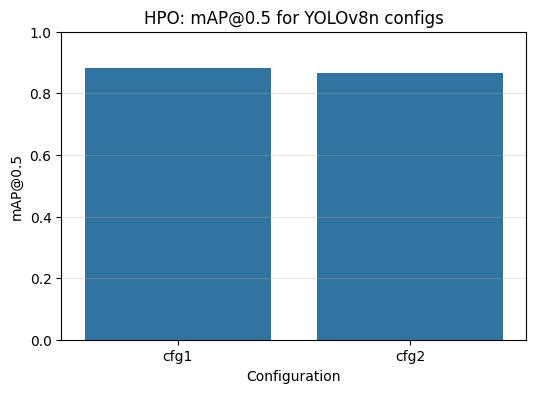

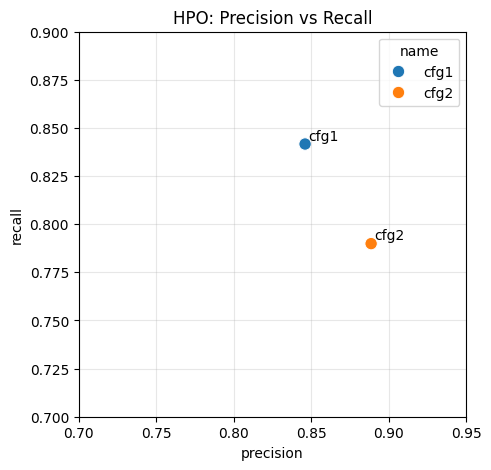

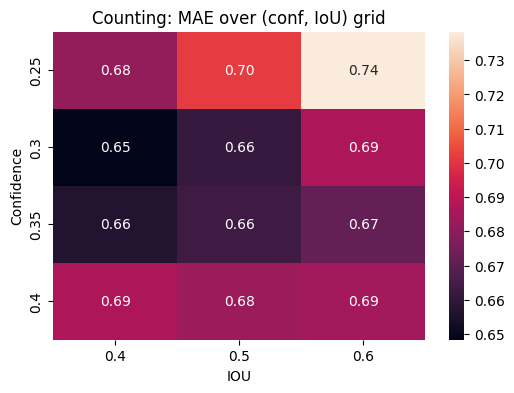

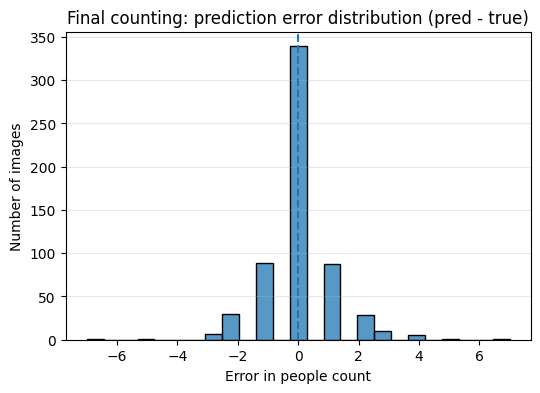

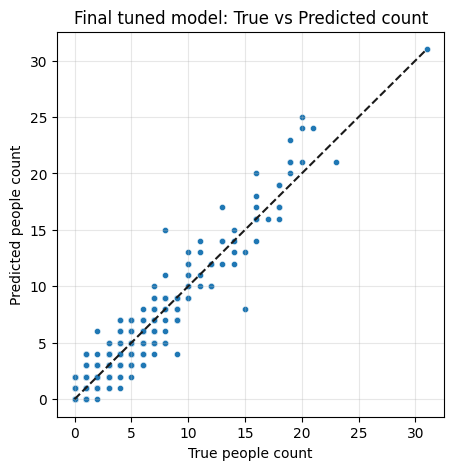

Metrics & graphs cell finished


In [12]:
# Detailed metrics & graphs
for var in ["hpo_df", "sweep_df", "counts_df"]:
  if var not in globals():
    raise RuntimeError(
        f"{var} is not defined. "
        "Make sure you have run the full training script above."
    )

print("Hyperparameter Search (HPO) Summary")
print(hpo_df, "\n")

# HPO: Bar chart of mAP@0.5 for cfg1 vs cfg2
plt.figure(figsize = (6, 4))
sns.barplot(data = hpo_df, x = "name", y = "mAP@0.5")
plt.title("HPO: mAP@0.5 for YOLOv8n configs")
plt.xlabel("Configuration")
plt.ylabel("mAP@0.5")
plt.ylim(0, 1.0)
plt.grid(axis = "y", alpha = 0.3)
plt.show()

# 2) HPO: Precision vs Recall scatter
plt.figure(figsize = (5, 5))
sns.scatterplot(data = hpo_df, x = "precision", y = "recall", hue = "name", s = 80)
for _, row in hpo_df.iterrows():
  plt.text(row["precision"] + 0.002, row["recall"] + 0.002, row["name"])
plt.xlim(0.7, 0.95)
plt.ylim(0.7, 0.9)
plt.title("HPO: Precision vs Recall")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Threshold sweep heatmap: MAE vs (conf, IoU)
pivot_mae = sweep_df.pivot(index = "conf", columns = "iou", values = "MAE")
plt.figure(figsize = (6, 4))
sns.heatmap(pivot_mae, annot = True, fmt = ".2f")
plt.title("Counting: MAE over (conf, IoU) grid")
plt.xlabel("IOU")
plt.ylabel("Confidence")
plt.show()

# 4) Final counting metrics: error distribution histogram
plt.figure(figsize = (6, 4))
sns.histplot(counts_df["err"], bins = 25, kde = False)
plt.axvline(0, linestyle="--")
plt.title("Final counting: prediction error distribution (pred - true)")
plt.xlabel("Error in people count")
plt.ylabel("Number of images")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 5) Final counting: True vs Pred scatter
plt.figure(figsize = (5, 5))
sns.scatterplot(data = counts_df, x = "true", y = "pred", s = 20)
max_count = int(max(counts_df["true"].max(), counts_df["pred"].max()))
plt.plot([0, max_count], [0, max_count], "k--")
plt.xlabel("True people count")
plt.ylabel("Predicted people count")
plt.title("Final tuned model: True vs Predicted count")
plt.grid(True, alpha=0.3)
plt.show()

print("Metrics & graphs cell finished")


Loading training curves from: /content/runs_people_yolo/best_long_20e/results.csv


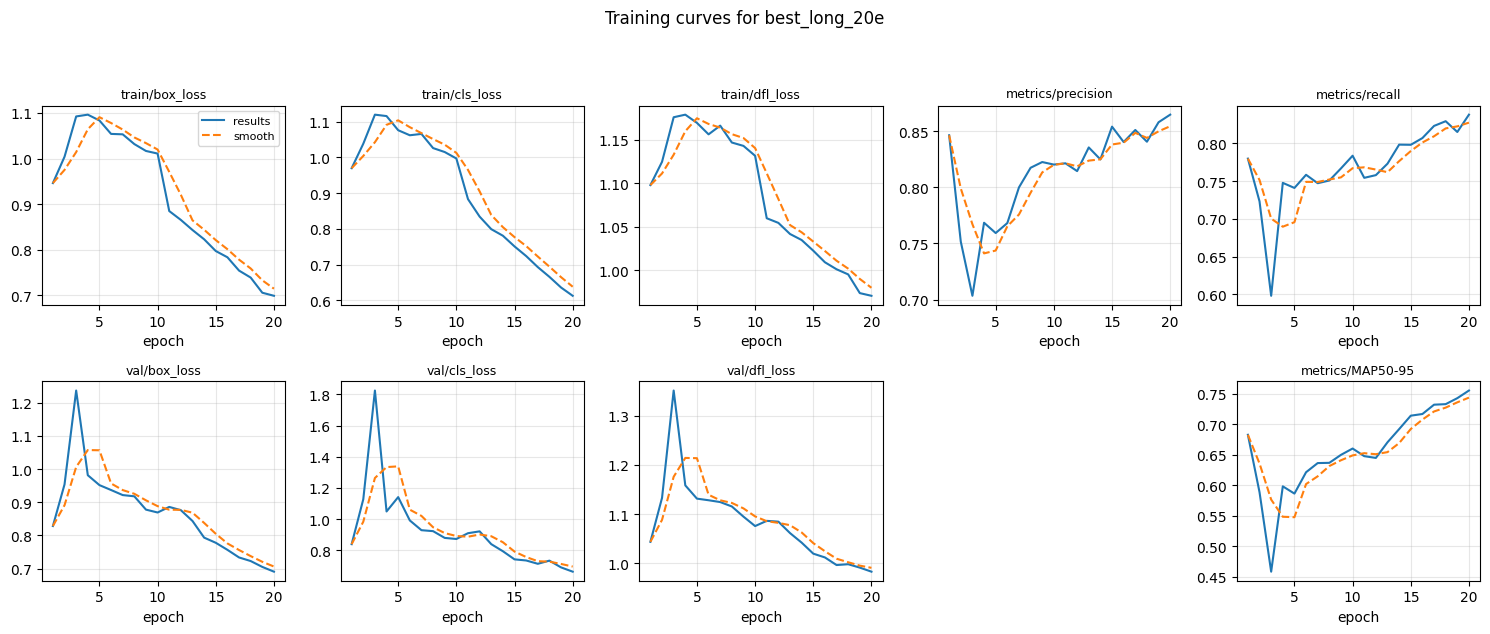

Loss curve plots done.


In [13]:
# Loss & metrics plots
results_csv = Path(best_run_dir) / "results.csv"
print("\nLoading training curves from:", results_csv)

if not results_csv.exists():
  raise FileNotFoundError(
    f"results.csv not found at {results_csv}. "
    "Ensure training completed successfully."
  )

res_df = pd.read_csv(results_csv)
res_df["epoch"] = res_df.index + 1

def pick_col(candidates):
  for c in candidates:
    if c in res_df.columns:
      return c

  return None

plots = [
(["train/box_loss"], "train/box_loss"),
(["train/cls_loss"], "train/cls_loss"),
(["train/dfl_loss"], "train/dfl_loss"),
(["metrics/precision(B)", "metrics/precision"], "metrics/precision"),
(["metrics/recall(B)", "metrics/recall"], "metrics/recall"),
(["val/box_loss"], "val/box_loss"),
(["val/cls_loss"], "val/cls_loss"),
(["val/dfl_loss"], "val/dfl_loss"),
(["metrics/mAP50 (B)", "metrics/mAP50"], "metrics/MAP50"),
(["metrics/mAP50-95(B)", "metrics/mAP50-95"], "metrics/MAP50-95"),
]

n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 6))
axes = axes.flatten()

for ax, (candidates, title) in zip(axes, plots):
  col = pick_col(candidates)

  if col is None:
    ax.set_visible(False)
    continue

  y = res_df[col]
  smooth = y.rolling(window = 3, min_periods = 1).mean()

  ax.plot(res_df["epoch"], y, label = "results")
  ax.plot(res_df["epoch"], smooth, linestyle = "--", label = "smooth")
  ax.set_title(title, fontsize = 9)
  ax.set_xlabel("epoch")
  ax.grid(True, alpha = 0.3)

for ax in axes:
  if ax.get_visible():
    ax.legend(fontsize = 8)
    break

fig.suptitle(f"Training curves for {best_run_dir.name}", y = 1.05)

plt.tight_layout()
plt.show()
print("Loss curve plots done.")

Qualitative Detection (Demo Images):

Showing 5 demo images with YOLOv8n predictions.


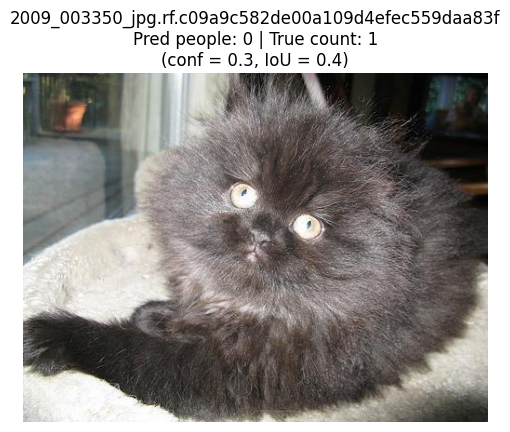

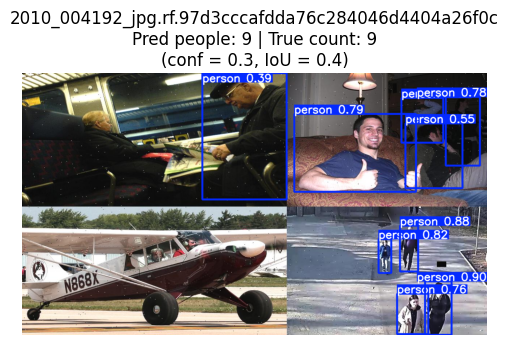

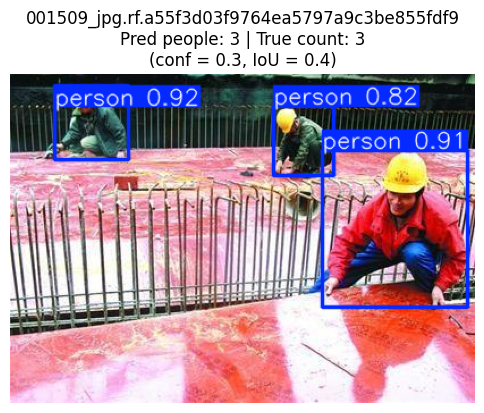

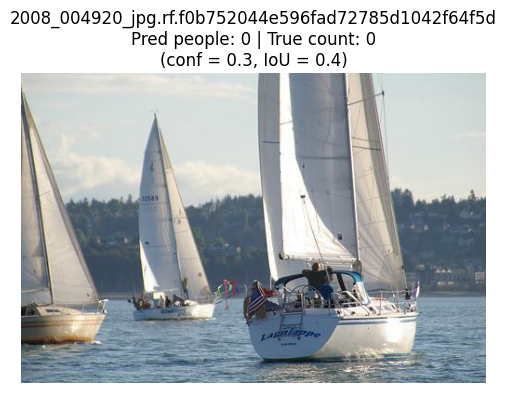

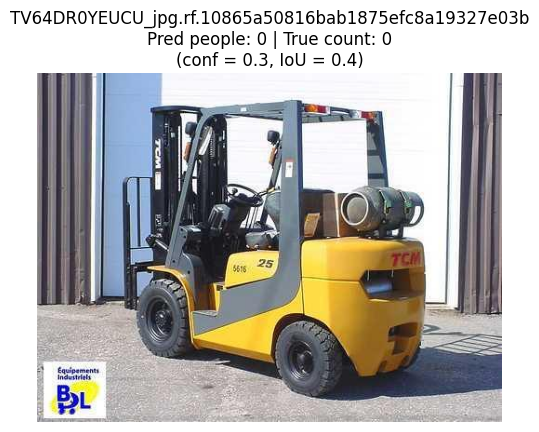

Demo visualization done.


In [14]:
# Demo, predictions are visualized with bounding boxes and counts
needed_vars = ["best_model", "best_imgsz", "best_conf", "best_iou", "images_val", "image_exts", "label_counts_val"]
for var in needed_vars:
  if var not in globals():
    raise RuntimeError(
        f"{var} is not defined. "
        "Make sure you have run the full training script above."
    )

demo_val_imgs = sorted([p for p in images_val.glob("*") if p.suffix.lower() in image_exts])
n_demo = min(5, len(demo_val_imgs))
demo_imgs = random.sample(demo_val_imgs, n_demo)
print(f"Showing {n_demo} demo images with YOLOv8n predictions.")

results = best_model.predict(
    source = demo_imgs,
    imgsz = best_imgsz,
    conf = best_conf,
    iou = best_iou,
    stream = True,
    verbose = False,
    max_det = 200
)

for r in results:
  img_path = Path(r.path)
  name = img_path.stem

  true_count = label_counts_val.get(name, 0)

  if r.boxes is not None:
    pred_count = int((r.boxes.cls == 0).sum())
  else:
    pred_count = 0

  plotted = r.plot()
  plotted_rgb = cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)

  plt.figure(figsize = (6, 6))
  plt.imshow(plotted_rgb)
  plt.axis("off")
  plt.title(
      f"{name}\n"
      f"Pred people: {pred_count} | True count: {true_count}\n"
      f"(conf = {best_conf}, IoU = {best_iou})"
  )
  plt.show()

print("Demo visualization done.")